# ARK Updates Analysis

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Description](#Data-Description)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Grouping and Aggregation](#Grouping-and-Aggregation)
5. [Identifying Anomalous Versions](#Identifying-Anomalous-Versions)
6. [Visualizing Update Data](#Visualizing-Update-Data)
7. [Monthly Resampling and Feature Engineering](#Monthly-Resampling-and-Feature-Engineering)
8. [Defining and Analyzing Activity Periods](#Defining-and-Analyzing-Activity-Periods)
9. [Visualizing Activity Periods and Analyzing Seasonality](#Visualizing-Activity-Periods-and-Analyzing-Seasonality)
10. [Statistical Tests and Analysis](#Statistical-Tests-and-Analysis)
11. [Save Analysis Results](#Save-Analysis-Results)

## Introduction
The purpose of this analysis is to:
- Examine the frequency and patterns of updates for the ARK game.
- Provide insights into the development cycle.
- Help predict future updates.
- Identify periods of high and low activity for planning game events or releases.

## Data Description
The dataset includes:
- Dates and descriptions of each update.
- Data collected from official ARK update logs.
- Preprocessed to ensure consistency and accuracy.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Load the update data
ark_update_data = pd.read_csv('data/ark/ark_updates_collection.csv')

# Display the first few rows of the data
print(ark_update_data.head())

         Date  Version  Num_Changes  \
0  2023-05-04  v357.18            2   
1  2023-05-04  v357.17            2   
2  2023-04-26  v357.15            1   
3  2023-04-14  v357.14            1   
4  2023-04-12  v357.13            1   

                                             Changes Category  
0  Added a command line unofficial admins can opt...    Minor  
1  Fixed multiple exploits v357.17 - 05/04/2023 -...    Minor  
2   v357.15 - 04/26/2023 - Minor version for servers    Minor  
3   v357.14 - 04/14/2023 - Minor version for servers    Minor  
4   v357.13 - 04/12/2023 - Minor version for servers    Minor  


In [2]:
# Convert the 'Date' column to datetime
ark_update_data['Date'] = pd.to_datetime(ark_update_data['Date'], format='%Y-%m-%d')

# Extract major and minor version numbers
ark_update_data['Major_Version'] = ark_update_data['Version'].str.extract('v(\d+)').astype(float)
ark_update_data['Minor_Version'] = ark_update_data['Version'].str.extract('v\d+\.(\d+)').astype(float)

# Fill NaN values in Minor_Version with 0
ark_update_data['Minor_Version'] = ark_update_data['Minor_Version'].fillna(0)

# Create a combined version number
ark_update_data['Combined_Version'] = ark_update_data['Major_Version'] + ark_update_data['Minor_Version'] / 100

# Sort the dataframe by date
ark_update_data = ark_update_data.sort_values('Date')

# Reset the index
ark_update_data = ark_update_data.reset_index(drop=True)

print(ark_update_data.head())

        Date  Version  Num_Changes  \
0 2019-08-08   v298.3            3   
1 2019-08-23  v298.31            4   
2 2019-08-27  v298.37            3   
3 2019-09-16  v298.40           14   
4 2019-09-18  v298.41            3   

                                             Changes Category  Major_Version  \
0  Added -pvedisallowtribewar flag Added 'cheat t...   Before          298.0   
1  Set beer barrels to check for enemy foundation...    Minor          298.0   
2  Fixed a server crash when using the grapple ho...   Before          298.0   
3  Fixed an exploit with Tek sword dash and zipli...   Before          298.0   
4  Added HLN-A Explorer Notes 1-5 for Genesis Chr...   Before          298.0   

   Minor_Version  Combined_Version  
0            3.0            298.03  
1           31.0            298.31  
2           37.0            298.37  
3           40.0            298.40  
4           41.0            298.41  


In [3]:
# Group by major version and aggregate data
ark_grouped_df = ark_update_data.groupby('Major_Version').agg({
    'Date': ['min', 'max'],
    'Minor_Version': 'count',
    'Num_Changes': 'sum'
}).reset_index()

# Rename columns
ark_grouped_df.columns = ['Major_Version', 'Start_Date', 'End_Date', 'Minor_Versions', 'Total_Changes']

print(ark_grouped_df)

    Major_Version Start_Date   End_Date  Minor_Versions  Total_Changes
0           298.0 2019-08-08 2019-09-18               5             27
1           299.0 2019-10-10 2019-10-10               2              5
2           300.0 2019-10-22 2019-11-05               6             11
3           301.0 2019-11-08 2019-11-08               1              2
4           302.0 2019-11-19 2019-12-04               7             52
5           303.0 2019-12-11 2019-12-11               1             11
6           304.0 2019-12-17 2020-02-06              22             57
7           305.0 2020-02-11 2020-02-11               1              0
8           306.0 2020-02-26 2020-03-05               3             26
9           307.0 2020-03-17 2020-03-24               5             39
10          309.0 2020-03-26 2020-04-03               4             30
11          310.0 2020-04-07 2020-06-10              19             70
12          311.0 2020-06-11 2020-06-19              12             36
13    

In [4]:
# Identify the anomalous versions
anomalous_versions = ark_grouped_df[ark_grouped_df['Major_Version'] > 400]

# Get the date range for the anomalous versions
anomalous_start = anomalous_versions['Start_Date'].min()
anomalous_end = anomalous_versions['End_Date'].max()

# Print the change categories for the anomalous versions
print("Change categories for anomalous versions:")
anomalous_changes = ark_update_data[
    (ark_update_data['Major_Version'] > 400) & 
    (ark_update_data['Date'] >= anomalous_start) & 
    (ark_update_data['Date'] <= anomalous_end)
]
print(anomalous_changes[['Date', 'Version', 'Category', 'Changes']])

# Check for overlapping updates
overlapping_updates = ark_update_data[
    (ark_update_data['Major_Version'] <= 400) & 
    (ark_update_data['Date'] >= anomalous_start) & 
    (ark_update_data['Date'] <= anomalous_end)
]

if not overlapping_updates.empty:
    print("\nOverlapping updates during the same period:")
    print(overlapping_updates[['Date', 'Version', 'Category', 'Changes']])
else:
    print("\nNo overlapping updates found during this period.")

# Print the updates just before and after the anomalous period
buffer_days = 7  # Adjust this to look further before/after if needed
print(f"\nUpdates within {buffer_days} days before the anomalous period:")
before_anomaly = ark_update_data[
    (ark_update_data['Date'] >= anomalous_start - pd.Timedelta(days=buffer_days)) & 
    (ark_update_data['Date'] < anomalous_start)
]
print(before_anomaly[['Date', 'Version', 'Category', 'Changes']])

print(f"\nUpdates within {buffer_days} days after the anomalous period:")
after_anomaly = ark_update_data[
    (ark_update_data['Date'] > anomalous_end) & 
    (ark_update_data['Date'] <= anomalous_end + pd.Timedelta(days=buffer_days))
]
print(after_anomaly[['Date', 'Version', 'Category', 'Changes']])

Change categories for anomalous versions:
          Date  Version Category  \
211 2021-08-31  v678.10   Before   
212 2021-09-02  v678.13   Before   
213 2021-09-08  v678.20   Before   
214 2021-09-10  v678.30   Before   
215 2021-09-10  v678.32   Before   
216 2021-09-10  v678.37   Before   
217 2021-09-14  v678.45   Before   
218 2021-09-15  v678.46   Before   
219 2021-09-17  v678.51   Before   

                                               Changes  
211  Fixed some crashes Fixed some cases where Miss...  
212  Fixed a bug where Mini-HLNA emotes didn't play...  
213       Fixed multiple exploits v678.20 - 09/08/2021  
214                               v678.30 - 09/10/2021  
215                               v678.32 - 09/10/2021  
216  Refactored TEK Dedicated Storage. This is a re...  
217                               v678.45 - 09/14/2021  
218  Fixed a bug where Explorer Notes would not unl...  
219  Fixed a bug where pressing "Spacebar" to bring...  

No overlapping updates fou

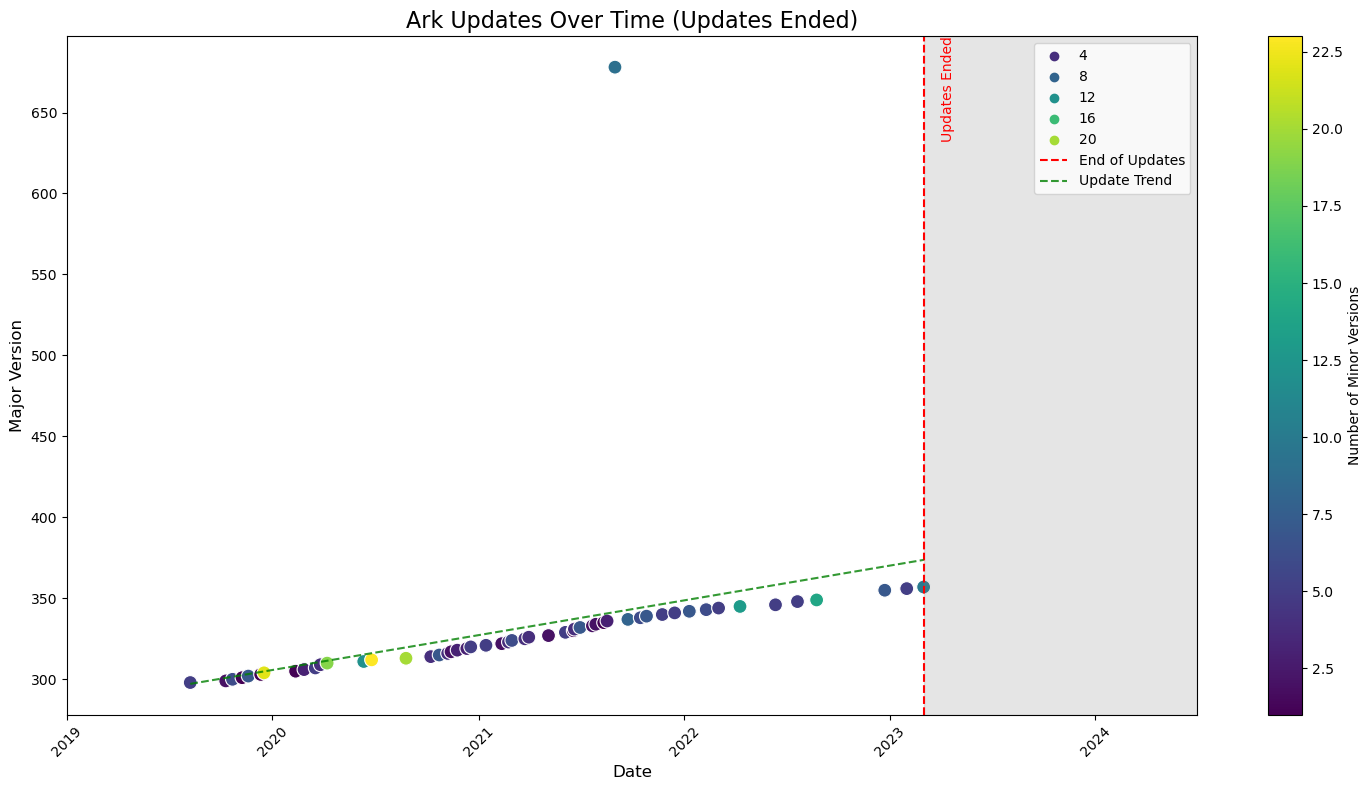

       Major_Version                     Start_Date  \
count      53.000000                             53   
mean      331.792453  2021-03-18 17:12:27.169811200   
min       298.000000            2019-08-08 00:00:00   
25%       312.000000            2020-06-25 00:00:00   
50%       325.000000            2021-03-24 00:00:00   
75%       339.000000            2021-10-15 00:00:00   
max       678.000000            2023-03-02 00:00:00   
std        51.159012                            NaN   

                            End_Date  Minor_Versions  Total_Changes  
count                             53       53.000000      53.000000  
mean   2021-04-05 04:58:52.075471616        6.188679      24.433962  
min              2019-09-18 00:00:00        1.000000       0.000000  
25%              2020-08-18 00:00:00        3.000000      10.000000  
50%              2021-03-29 00:00:00        5.000000      21.000000  
75%              2021-10-21 00:00:00        7.000000      30.000000  
max           

In [5]:
# Creates a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15, 8))

# Creates the scatter plot
scatter = sns.scatterplot(data=ark_grouped_df, 
                          x='Start_Date', 
                          y='Major_Version', 
                          hue='Minor_Versions', 
                          palette='viridis',
                          s=100,
                          ax=ax)

# Customizing the plot
ax.set_title('Ark Updates Over Time (Updates Ended)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Major Version', fontsize=12)
plt.xticks(rotation=45)

# Adds colorbar legend
norm = plt.Normalize(ark_grouped_df['Minor_Versions'].min(), ark_grouped_df['Minor_Versions'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="Number of Minor Versions")
cbar.ax.tick_params(labelsize=10)

# Removes the automatic legend
ax.get_legend().remove()

# Sets x-axis limits
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 6, 30)
ax.set_xlim(start_date, end_date)

# Find the last update date
last_update_date = ark_grouped_df['Start_Date'].max()

# Add a vertical line to indicate the end of updates
ax.axvline(x=last_update_date, color='r', linestyle='--', label='End of Updates')

# Add text annotation for end of updates
ax.text(last_update_date + timedelta(days=30), ax.get_ylim()[1], 'Updates Ended', 
        rotation=90, verticalalignment='top', color='r')

# Shade the area after updates ended
ax.axvspan(last_update_date, end_date, alpha=0.2, color='gray')

# Add a trend line (only up to the last update)
dates_ordinal = [date.toordinal() for date in ark_grouped_df['Start_Date']]
major_versions = ark_grouped_df['Major_Version'].values

# Use numpy's polyfit to get the trend line coefficients
z = np.polyfit(dates_ordinal, major_versions, 1)
p = np.poly1d(z)

# Generate points for the trend line
trend_dates = pd.date_range(start=ark_grouped_df['Start_Date'].min(), end=last_update_date)
trend_dates_ordinal = [date.toordinal() for date in trend_dates]
trend_values = p(trend_dates_ordinal)

# Plot the trend line
ax.plot(trend_dates, trend_values, "g--", alpha=0.8, label='Update Trend')

# Add legend
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics and update frequency
print(ark_grouped_df.describe())
update_frequency = ark_grouped_df['Start_Date'].diff().mean()
print(f"Average time between major updates: {update_frequency.days} days")
print(f"Last update was on: {last_update_date.strftime('%Y-%m-%d')}")

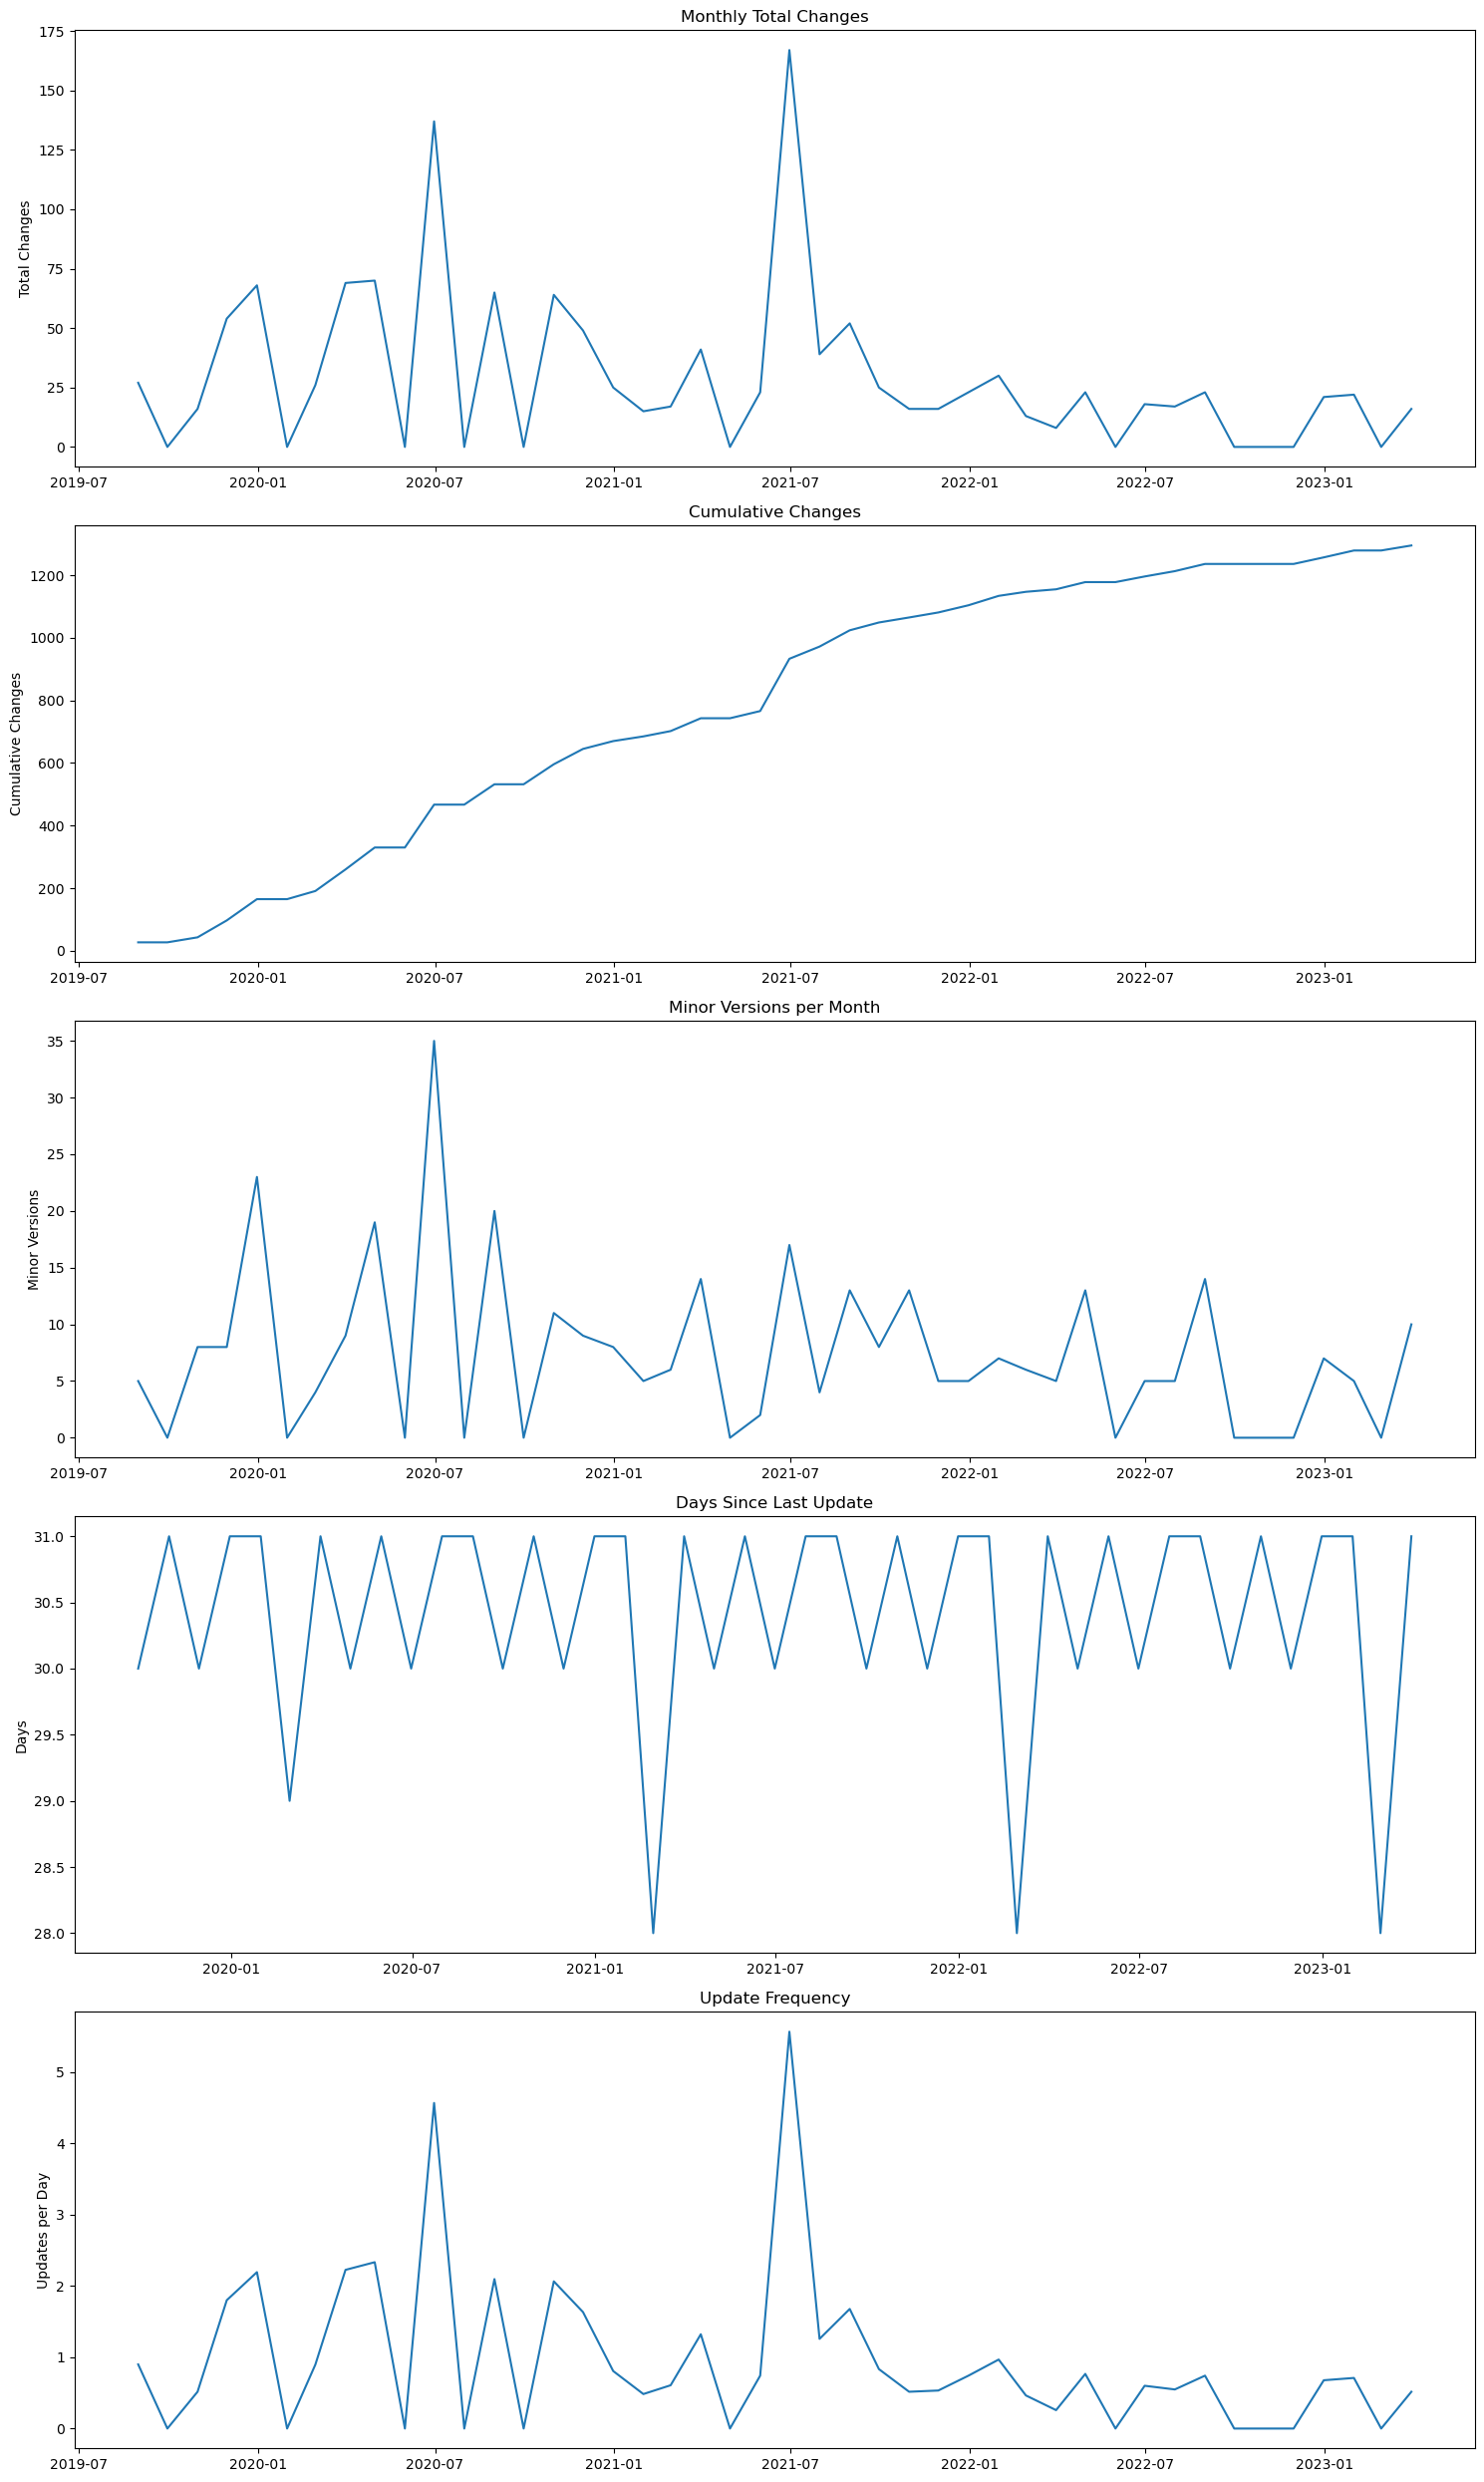

                          Start_Date  Major_Version  Minor_Versions  \
count                             44      44.000000       44.000000   
mean   2021-06-15 09:49:05.454545408     336.386364        7.454545   
min              2019-08-31 00:00:00     298.000000        0.000000   
25%              2020-07-23 06:00:00     312.000000        1.500000   
50%              2021-06-15 00:00:00     329.500000        5.500000   
75%              2022-05-07 18:00:00     345.250000       10.250000   
max              2023-03-31 00:00:00     678.000000       35.000000   
std                              NaN      55.852054        7.318198   

       Total_Changes  Cumulative_Changes  Days_Since_Last_Update  \
count      44.000000           44.000000               43.000000   
mean       29.431818          787.863636               30.418605   
min         0.000000           27.000000               28.000000   
25%         6.000000          467.000000               30.000000   
50%        21.500000

In [6]:
# Monthly resampling and feature engineering
ark_monthly = ark_grouped_df.set_index('Start_Date').resample('ME').agg({
    'Major_Version': 'last',
    'Minor_Versions': 'sum',
    'Total_Changes': 'sum'
}).reset_index()

# Fill NaN values with forward fill method
ark_monthly = ark_monthly.ffill()

# Create feature for cumulative changes
ark_monthly['Cumulative_Changes'] = ark_monthly['Total_Changes'].cumsum()

# Create a feature for days since last update
ark_monthly['Days_Since_Last_Update'] = ark_monthly['Start_Date'].diff().dt.days

# Calculate update frequency (number of updates per day)
ark_monthly['Days_In_Period'] = ark_monthly['Start_Date'].diff().dt.days.fillna(30)  # Fill the first period with 30 days
ark_monthly['Update_Frequency'] = ark_monthly['Total_Changes'] / ark_monthly['Days_In_Period']

# Visualize the monthly data
plt.figure(figsize=(15, 25))

plt.subplot(5, 1, 1)
plt.plot(ark_monthly['Start_Date'], ark_monthly['Total_Changes'])
plt.title('Monthly Total Changes')
plt.ylabel('Total Changes')

plt.subplot(5, 1, 2)
plt.plot(ark_monthly['Start_Date'], ark_monthly['Cumulative_Changes'])
plt.title('Cumulative Changes')
plt.ylabel('Cumulative Changes')

plt.subplot(5, 1, 3)
plt.plot(ark_monthly['Start_Date'], ark_monthly['Minor_Versions'])
plt.title('Minor Versions per Month')
plt.ylabel('Minor Versions')

plt.subplot(5, 1, 4)
plt.plot(ark_monthly['Start_Date'], ark_monthly['Days_Since_Last_Update'])
plt.title('Days Since Last Update')
plt.ylabel('Days')

plt.subplot(5, 1, 5)
plt.plot(ark_monthly['Start_Date'], ark_monthly['Update_Frequency'])
plt.title('Update Frequency')
plt.ylabel('Updates per Day')

plt.tight_layout()
plt.show()

# Print summary statistics
print(ark_monthly.describe())

# Print the first few rows of the monthly data
print(ark_monthly.head())


In [7]:
# Define low and high activity based on percentiles
low_threshold = ark_monthly['Update_Frequency'].quantile(0.25)  # 25th percentile
high_threshold = ark_monthly['Update_Frequency'].quantile(0.75)  # 75th percentile

low_activity = ark_monthly[ark_monthly['Update_Frequency'] <= low_threshold].copy()
high_activity = ark_monthly[ark_monthly['Update_Frequency'] >= high_threshold].copy()

print("Periods of low update activity (bottom 25%):")
print(low_activity[['Start_Date', 'Total_Changes', 'Days_Since_Last_Update', 'Update_Frequency']])

print("\nPeriods of high update activity (top 25%):")
print(high_activity[['Start_Date', 'Total_Changes', 'Days_Since_Last_Update', 'Update_Frequency']])

Periods of low update activity (bottom 25%):
   Start_Date  Total_Changes  Days_Since_Last_Update  Update_Frequency
1  2019-09-30              0                    30.0               0.0
5  2020-01-31              0                    31.0               0.0
9  2020-05-31              0                    31.0               0.0
11 2020-07-31              0                    31.0               0.0
13 2020-09-30              0                    30.0               0.0
20 2021-04-30              0                    30.0               0.0
33 2022-05-31              0                    31.0               0.0
37 2022-09-30              0                    30.0               0.0
38 2022-10-31              0                    31.0               0.0
39 2022-11-30              0                    30.0               0.0
42 2023-02-28              0                    28.0               0.0

Periods of high update activity (top 25%):
   Start_Date  Total_Changes  Days_Since_Last_Update  Updat

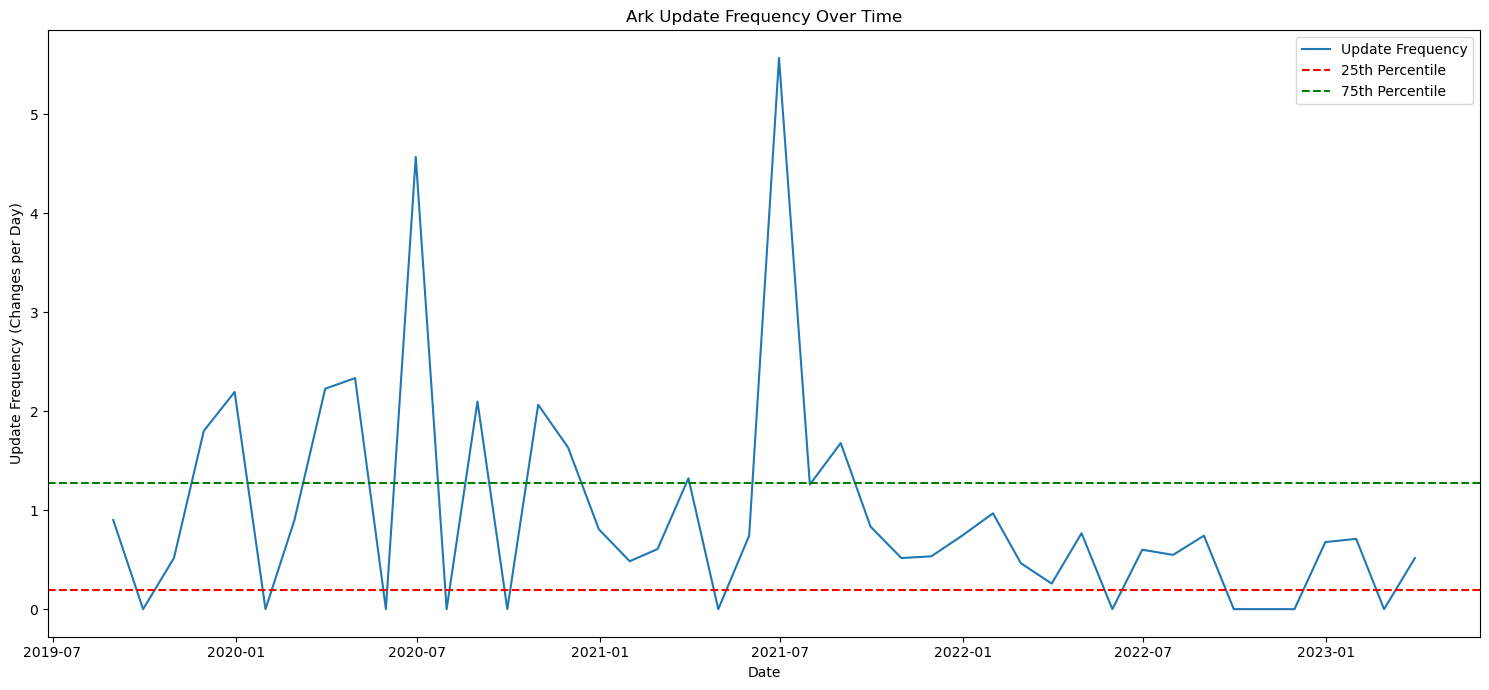


Median update frequency: 0.69 changes per day
25th percentile (low activity threshold): 0.19 changes per day
75th percentile (high activity threshold): 1.27 changes per day

Low activity periods by year:
Year
2019    1
2020    4
2021    1
2022    4
2023    1
Name: count, dtype: int64

High activity periods by year:
Year
2019    2
2020    6
2021    3
Name: count, dtype: int64

Low activity periods by month:
Month
1     1
2     1
4     1
5     2
7     1
9     3
10    1
11    1
Name: count, dtype: int64

High activity periods by month:
Month
3     2
4     1
6     2
8     2
10    1
11    2
12    1
Name: count, dtype: int64


In [8]:
# Visualize with new thresholds
plt.figure(figsize=(15, 7))
plt.plot(ark_monthly['Start_Date'], ark_monthly['Update_Frequency'], label='Update Frequency')
plt.title('Ark Update Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Update Frequency (Changes per Day)')
plt.axhline(y=low_threshold, color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=high_threshold, color='g', linestyle='--', label='75th Percentile')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate some statistics
print(f"\nMedian update frequency: {ark_monthly['Update_Frequency'].median():.2f} changes per day")
print(f"25th percentile (low activity threshold): {low_threshold:.2f} changes per day")
print(f"75th percentile (high activity threshold): {high_threshold:.2f} changes per day")

# Analyze patterns in low and high activity periods
low_activity.loc[:, 'Year'] = low_activity['Start_Date'].dt.year
high_activity.loc[:, 'Year'] = high_activity['Start_Date'].dt.year

print("\nLow activity periods by year:")
print(low_activity['Year'].value_counts().sort_index())

print("\nHigh activity periods by year:")
print(high_activity['Year'].value_counts().sort_index())

# Check for any seasonality
low_activity.loc[:, 'Month'] = low_activity['Start_Date'].dt.month
high_activity.loc[:, 'Month'] = high_activity['Start_Date'].dt.month

print("\nLow activity periods by month:")
print(low_activity['Month'].value_counts().sort_index())

print("\nHigh activity periods by month:")
print(high_activity['Month'].value_counts().sort_index())

T-Test results: t-statistic = -6.42, p-value = 0.0000

Correlation Matrix:
                        Total_Changes  Cumulative_Changes  \
Total_Changes                1.000000           -0.218064   
Cumulative_Changes          -0.218064            1.000000   
Days_Since_Last_Update       0.028951           -0.025640   

                        Days_Since_Last_Update  
Total_Changes                         0.028951  
Cumulative_Changes                   -0.025640  
Days_Since_Last_Update                1.000000  


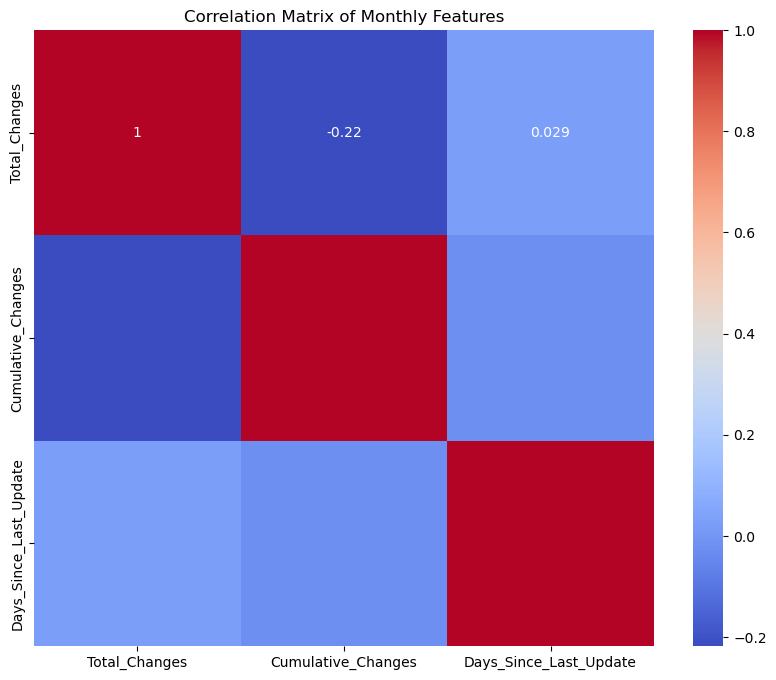

In [9]:
from scipy.stats import ttest_ind

# Perform t-test between low and high activity periods
t_stat, p_val = ttest_ind(low_activity['Total_Changes'], high_activity['Total_Changes'])
print(f"T-Test results: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Correlation analysis
correlation_matrix = ark_monthly[['Total_Changes', 'Cumulative_Changes', 'Days_Since_Last_Update']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Monthly Features')
plt.show()

In [10]:
import pickle

# Define a dictionary to hold the analysis results
analysis_results = {
    'ark_update_data': ark_update_data,
    'ark_grouped_df': ark_grouped_df,
    'ark_monthly': ark_monthly,
    'low_activity': low_activity,
    'high_activity': high_activity,
    't_test_results': {
        't_stat': t_stat,
        'p_val': p_val
    },
    'correlation_matrix': correlation_matrix
}

# Save the analysis results to a pickle file
with open('ark_updates_analysis.pkl', 'wb') as file:
    pickle.dump(analysis_results, file)

print("Analysis results have been saved to ark_updates_analysis.pkl")

Analysis results have been saved to ark_updates_analysis.pkl
